## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
video-games-sales-2019.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
!pip install category_encoders
!pip install optuna
!pip install pandas
!pip install japanize-matplotlib

None
     |████████████████████████████████| 82 kB 464 kB/s 
     |████████████████████████████████| 308 kB 7.0 MB/s 
     |████████████████████████████████| 209 kB 67.4 MB/s 
     |████████████████████████████████| 80 kB 12.7 MB/s 
     |████████████████████████████████| 75 kB 5.8 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 149 kB 75.3 MB/s 
     |████████████████████████████████| 112 kB 65.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f83a2356b5010b1b5e797cfa17de4db1d79b0b835d94f8bfa573f66e19c35690
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 4.1 MB 9.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=a235444d30393f2a816cb858c2261d7e8a08680e7b62bf187540478203506a55
  Stored in 

## cuda-tesne のインストール

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda101.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/

!conda install --offline tsnecuda-2.1.0-cuda101.tar.bz2

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...
--2021-12-11 12:05:49--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a987870581667a307cf?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda101.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda101.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20211211T120549Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3

## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted
from tqdm.notebook import tqdm

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
from tsnecuda import TSNE
from pandas import plotting 

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [ ]:
# 欠損の削除
X_train_dropna = X_train_ce.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ce.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

## 主成分分析

## PCA

In [ ]:
pca = PCA(copy=True, n_components=None, whiten=False)

feature = pca.fit_transform(X_train_dropna)

  0%|          | 0/11 [00:00<?, ?it/s]

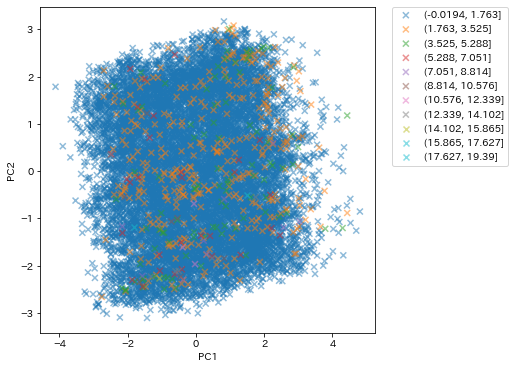

In [ ]:
bins_num = 11
labels, bins = pd.cut(y_train_dropna, bins_num, retbins=True, labels=range(bins_num))
cut, bins = pd.cut(y_train_dropna, bins_num, retbins=True)

# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))

for num in tqdm(range(bins_num)):
    plt.scatter(feature[:, 0][labels==num], feature[:, 1][labels==num], alpha=0.5,
                c=[plt.get_cmap("tab10")(x) for x in labels[labels==num]],
                label=natsorted(cut.unique())[num],
                marker="x"
                )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# 寄与率
pd.DataFrame(
    pca.explained_variance_ratio_, 
    index=["PC{}".format(x + 1) for x in range(len(X_train_dropna.columns))],
    columns=["寄与率"]
    ).T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
寄与率,0.112901,0.100128,0.081188,0.066939,0.064491,0.057514,0.054251,0.053522,0.051536,0.049655,0.048501,0.047001,0.045831,0.04325,0.042468,0.035735,0.033098,0.011016,0.000975,3.577040e-34,7.903421e-39


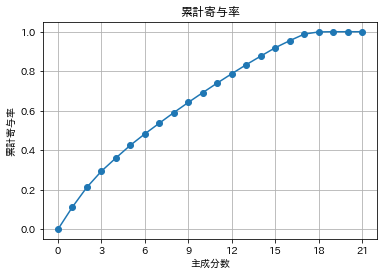

In [ ]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.title("累計寄与率")
plt.xlabel("主成分数")
plt.ylabel("累計寄与率")
plt.grid()
plt.show()

In [ ]:
# PCA の固有ベクトル
pd.DataFrame(
    pca.components_, 
    columns=X_train_dropna.columns, 
    index=["PC{}".format(x + 1) for x in range(len(X_train_dropna.columns))]
    )

,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,Platform,Publisher,Developer,Critic_Score,User_Score,Year,Last_Update,url,status,Vgchartzscore,img_url
PC1,-1.855943e-01,-1.191448e-01,-1.153045e-01,1.841858e-01,0.261640,-0.027537,-0.124559,-0.205682,-0.021388,-0.028857,-1.574422e-01,-1.271999e-01,-1.376415e-01,-1.208588e-02,1.869730e-03,-5.480959e-01,-6.851809e-03,-5.485339e-01,-0.000000e+00,-4.145102e-03,-3.382168e-01
PC2,-5.821658e-02,6.810382e-01,6.816978e-01,2.702966e-02,-0.050240,0.130323,-0.064974,-0.030179,-0.000186,-0.015711,1.754465e-02,4.196680e-02,4.521275e-02,5.393780e-03,9.704683e-03,-1.279262e-01,2.578510e-02,-1.360503e-01,0.000000e+00,2.236205e-02,-4.681456e-02
PC3,-1.701314e-01,-1.107940e-01,-1.100820e-01,-1.672041e-01,-0.657502,0.558788,0.187290,0.018064,-0.004255,-0.012396,2.479630e-01,-3.626050e-02,-1.519226e-02,2.557075e-02,8.393322e-03,-1.201054e-01,4.453658e-02,-1.884946e-01,-0.000000e+00,8.293905e-03,-1.510378e-01
PC4,6.756341e-02,4.234833e-02,4.446574e-02,2.579994e-01,0.016842,0.182148,-0.085248,-0.178753,-0.010731,0.017570,1.183421e-01,-6.235008e-01,-6.108551e-01,4.980328e-02,2.337005e-02,1.307859e-01,1.746711e-02,1.562390e-01,-0.000000e+00,4.504534e-02,1.709310e-01
PC5,-3.674545e-01,5.441923e-02,5.561696e-02,7.553610e-02,-0.032736,-0.484321,0.653343,0.015772,-0.013486,-0.027162,2.931592e-01,-9.305901e-02,-8.427341e-02,2.005097e-01,1.297508e-01,-1.232686e-02,-1.520829e-01,-4.594014e-02,-0.000000e+00,7.342017e-02,-5.241486e-03
PC6,-8.377878e-02,1.013213e-02,1.442087e-02,-1.923430e-02,-0.197375,-0.225763,-0.250756,0.852785,-0.003388,-0.032908,-1.112698e-01,-1.877740e-01,-1.884370e-01,-7.138463e-02,5.539461e-03,-8.552289e-02,-3.714931e-02,-9.580125e-02,0.000000e+00,6.161155e-02,-3.488078e-02
PC7,-1.507378e-01,-4.366924e-02,-4.309033e-02,1.608222e-01,0.052386,0.157536,-0.321855,0.024300,-0.053062,0.218884,8.709681e-02,1.369268e-01,1.284357e-01,4.867126e-01,3.553138e-01,2.682794e-02,-3.315528e-01,2.507431e-02,0.000000e+00,4.925087e-01,7.330614e-02
PC8,3.956424e-01,4.382503e-02,3.588988e-02,-4.024123e-01,-0.126779,-0.046199,0.271750,-0.092023,0.094784,0.274228,-4.753976e-01,-9.716362e-02,-1.765901e-01,-4.023034e-02,2.825425e-01,-9.925517e-02,-3.289890e-01,-4.309983e-02,1.734723e-18,1.468728e-01,-6.342647e-02
PC9,8.171193e-03,-8.538343e-04,2.450691e-03,1.500062e-01,-0.047737,-0.091838,0.032356,0.045736,-0.121458,0.848366,8.003763e-02,2.729047e-03,4.068600e-02,-5.131438e-02,7.379276e-02,-3.413296e-02,4.471407e-01,-2.319037e-02,-1.110223e-16,-1.034483e-01,-2.467861e-02
PC10,-8.408585e-02,1.019026e-02,6.522471e-03,2.988167e-02,-0.041321,-0.009089,-0.023042,-0.015207,0.475137,0.318458,-6.261201e-03,1.328970e-03,-1.720599e-02,1.553007e-01,-7.192761e-01,-9.375964e-03,-3.465663e-01,-2.132347e-03,-2.775558e-17,4.916786e-03,1.139701e-02


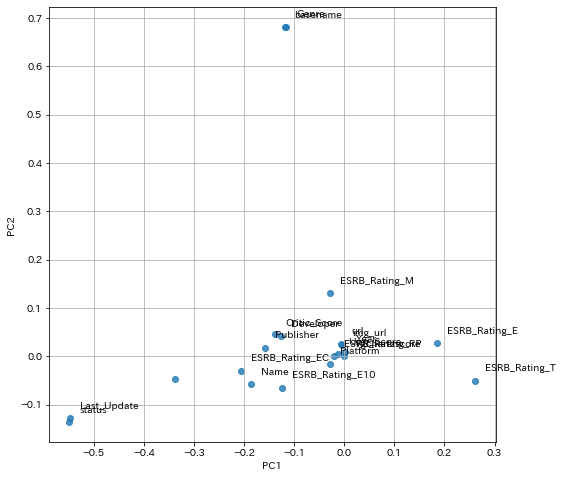

In [ ]:
# 第一主成分と第二主成分における観測変数の寄与度をプロットする
plt.figure(figsize=(8, 8))
for x, y, name in zip(pca.components_[0], pca.components_[1], X_train_dropna.columns[1:]):
    plt.text(x+0.02, y+0.02, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## TSNE(GPU使用)

,Global_Sales
"(-0.0194, 1.763]",12794
"(1.763, 3.525]",343
"(3.525, 5.288]",99
"(5.288, 7.051]",30
"(7.051, 8.814]",9
"(8.814, 10.576]",7
"(12.339, 14.102]",6
"(10.576, 12.339]",3
"(17.627, 19.39]",1
"(15.865, 17.627]",1


  0%|          | 0/18 [00:00<?, ?it/s]

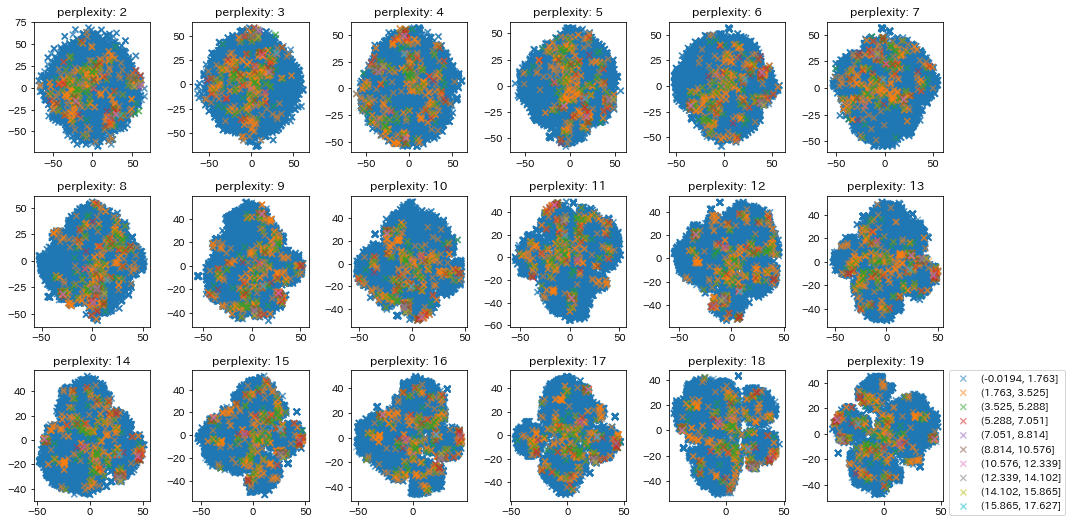

In [ ]:
fig = plt.figure(figsize=(15,12))

perplexities = 20

bins_num = 11
labels, bins = pd.cut(y_train_dropna, bins_num, retbins=True, labels=range(bins_num))
cuts, bins = pd.cut(y_train_dropna, bins_num, retbins=True)

display(pd.DataFrame(cuts.value_counts()))

for i in tqdm(range(2, perplexities)):

    plt.subplot(perplexities//4, 6, i-1)

    plt.title(f"perplexity: {i}")
    model_tsne = TSNE(n_components=2, perplexity=i)
    feature = model_tsne.fit_transform(X_train_dropna)

    # 第一主成分と第二主成分でプロットする

    for num in range(bins_num-1):
        plt.scatter(feature[:, 0][labels==num], feature[:, 1][labels==num], alpha=0.5,
                    c=[plt.get_cmap("tab10")(x) for x in labels[labels==num]],
                    label=natsorted(cuts.unique())[num],
                    marker="x"
                    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [ ]:
model_tsne = TSNE(n_components=2, perplexity=18)
feature = model_tsne.fit_transform(X_train_dropna)

(13294, 2)

[I 2021-12-11 12:16:40,648] A new study created in memory with name: no-name-b1a75ed8-5ac8-4454-b2b4-9202b1806cec
feature_fraction, val_score: 0.788655:  14%|#4        | 1/7 [00:00<00:00,  6.31it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.788655:  43%|####2     | 3/7 [00:00<00:00,  6.48it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.727204:  71%|#######1  | 5/7 [00:00<00:00,  6.19it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.630609	Test's rmse: 0.727204
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.727204:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	Train's rmse: 0.759359	Test's rmse: 0.788655
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.716031:   5%|5         | 1/20 [00:00<00:05,  3.28it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.624615	Test's rmse: 0.716031
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.716031:  10%|#         | 2/20 [00:00<00:04,  3.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.602075	Test's rmse: 0.726423
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  15%|#5        | 3/20 [00:00<00:05,  3.27it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.616237	Test's rmse: 0.711696
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  20%|##        | 4/20 [00:01<00:04,  3.23it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.620463	Test's rmse: 0.713347
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  25%|##5       | 5/20 [00:01<00:04,  3.03it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.616237	Test's rmse: 0.711696
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  30%|###       | 6/20 [00:02<00:05,  2.75it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.613121	Test's rmse: 0.71223
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  40%|####      | 8/20 [00:02<00:03,  3.21it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.609447	Test's rmse: 0.712166
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.636179	Test's rmse: 0.726571
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  45%|####5     | 9/20 [00:02<00:03,  3.46it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.641336	Test's rmse: 0.718207
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  50%|#####     | 10/20 [00:03<00:03,  3.27it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.613589	Test's rmse: 0.713378
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  55%|#####5    | 11/20 [00:03<00:03,  2.64it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.605465	Test's rmse: 0.712282
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.711696:  60%|######    | 12/20 [00:04<00:03,  2.49it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.612375	Test's rmse: 0.712302
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  65%|######5   | 13/20 [00:04<00:02,  2.41it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606281	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  70%|#######   | 14/20 [00:05<00:02,  2.30it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.602318	Test's rmse: 0.71257
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  75%|#######5  | 15/20 [00:05<00:02,  2.31it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.612497	Test's rmse: 0.712862
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  80%|########  | 16/20 [00:06<00:01,  2.09it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.597858	Test's rmse: 0.71138
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  85%|########5 | 17/20 [00:06<00:01,  2.00it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.597858	Test's rmse: 0.71138
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  90%|######### | 18/20 [00:07<00:00,  2.01it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.612283	Test's rmse: 0.713581
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.710864:  95%|#########5| 19/20 [00:07<00:00,  2.07it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.617976	Test's rmse: 0.711811
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.603644	Test's rmse: 0.711825
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  10%|#         | 1/10 [00:00<00:04,  1.81it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.616774	Test's rmse: 0.711036
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  20%|##        | 2/10 [00:01<00:04,  1.70it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.608602	Test's rmse: 0.726225
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  30%|###       | 3/10 [00:01<00:03,  1.82it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.610842	Test's rmse: 0.714553
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  40%|####      | 4/10 [00:02<00:03,  1.90it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.598753	Test's rmse: 0.718602
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  50%|#####     | 5/10 [00:02<00:02,  2.07it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.62421	Test's rmse: 0.714849
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  60%|######    | 6/10 [00:03<00:01,  2.04it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.636669	Test's rmse: 0.715709
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  70%|#######   | 7/10 [00:03<00:01,  1.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550157	Test's rmse: 0.728611
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  80%|########  | 8/10 [00:04<00:01,  1.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551861	Test's rmse: 0.727286
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.710864:  90%|######### | 9/10 [00:05<00:00,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.592459	Test's rmse: 0.733979
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.710864:   0%|          | 0/3 [00:00<?, ?it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.61158	Test's rmse: 0.724885
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.710864:  33%|###3      | 1/3 [00:00<00:00,  3.35it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.758046	Test's rmse: 0.792742
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.710864:  67%|######6   | 2/3 [00:00<00:00,  3.36it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.758046	Test's rmse: 0.792742
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.758046	Test's rmse: 0.792742
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:   5%|5         | 1/20 [00:00<00:08,  2.16it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606281	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  10%|#         | 2/20 [00:00<00:07,  2.30it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.612299	Test's rmse: 0.712483
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  15%|#5        | 3/20 [00:01<00:07,  2.19it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.602483	Test's rmse: 0.712114
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  20%|##        | 4/20 [00:01<00:07,  2.21it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.601215	Test's rmse: 0.71268
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  25%|##5       | 5/20 [00:02<00:06,  2.27it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.625837	Test's rmse: 0.714049
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  30%|###       | 6/20 [00:02<00:05,  2.34it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.619291	Test's rmse: 0.713868
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  35%|###5      | 7/20 [00:03<00:05,  2.34it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606281	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  40%|####      | 8/20 [00:03<00:05,  2.30it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606351	Test's rmse: 0.710869
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  45%|####5     | 9/20 [00:03<00:04,  2.27it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606281	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  50%|#####     | 10/20 [00:04<00:04,  2.29it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.616975	Test's rmse: 0.711185
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  55%|#####5    | 11/20 [00:04<00:04,  2.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.566736	Test's rmse: 0.720891
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  60%|######    | 12/20 [00:05<00:03,  2.09it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606281	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710864:  65%|######5   | 13/20 [00:05<00:03,  2.16it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606282	Test's rmse: 0.710864
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  70%|#######   | 14/20 [00:06<00:02,  2.15it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606282	Test's rmse: 0.710863
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  75%|#######5  | 15/20 [00:06<00:02,  2.20it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606284	Test's rmse: 0.710863
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  80%|########  | 16/20 [00:07<00:01,  2.20it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.606284	Test's rmse: 0.710863
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  85%|########5 | 17/20 [00:07<00:01,  2.25it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.624247	Test's rmse: 0.716425
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  90%|######### | 18/20 [00:08<00:00,  2.24it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.607779	Test's rmse: 0.711388
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.710863:  95%|#########5| 19/20 [00:08<00:00,  2.22it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.606574	Test's rmse: 0.711778
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.60064	Test's rmse: 0.713393
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863:  20%|##        | 1/5 [00:00<00:02,  1.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.612138	Test's rmse: 0.718334
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863:  40%|####      | 2/5 [00:01<00:01,  1.92it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.613006	Test's rmse: 0.714523
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863:  60%|######    | 3/5 [00:01<00:00,  2.46it/s]

Early stopping, best iteration is:
[11]	Train's rmse: 0.61538	Test's rmse: 0.727161
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863:  80%|########  | 4/5 [00:01<00:00,  2.68it/s]

Early stopping, best iteration is:
[20]	Train's rmse: 0.606008	Test's rmse: 0.712392
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.710863: 100%|##########| 5/5 [00:02<00:00,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.657755	Test's rmse: 0.725369


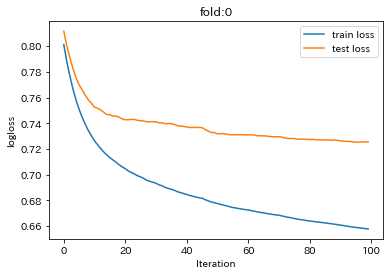

[I 2021-12-11 12:17:07,767] A new study created in memory with name: no-name-57907354-ecbb-40db-abbe-c6940082d486
feature_fraction, val_score: 0.796635:  14%|#4        | 1/7 [00:00<00:00,  6.57it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.717425:  43%|####2     | 3/7 [00:00<00:00,  6.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.630444	Test's rmse: 0.717425
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.717425:  71%|#######1  | 5/7 [00:00<00:00,  6.56it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.717425:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	Train's rmse: 0.755574	Test's rmse: 0.796635
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.705215:   5%|5         | 1/20 [00:00<00:07,  2.51it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.603268	Test's rmse: 0.705215
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.704226:  10%|#         | 2/20 [00:00<00:07,  2.26it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.615203	Test's rmse: 0.704226
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.704226:  15%|#5        | 3/20 [00:01<00:07,  2.39it/s]

Early stopping, best iteration is:
[22]	Train's rmse: 0.631942	Test's rmse: 0.705564
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.702585:  20%|##        | 4/20 [00:01<00:06,  2.31it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.618488	Test's rmse: 0.702585
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.702585:  25%|##5       | 5/20 [00:02<00:05,  2.67it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.623335	Test's rmse: 0.708554
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.702585:  30%|###       | 6/20 [00:02<00:05,  2.71it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.617073	Test's rmse: 0.706864
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.702585:  35%|###5      | 7/20 [00:02<00:05,  2.44it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.606435	Test's rmse: 0.7045
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700893:  40%|####      | 8/20 [00:03<00:04,  2.42it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.611796	Test's rmse: 0.700893
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700893:  45%|####5     | 9/20 [00:03<00:04,  2.57it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.626709	Test's rmse: 0.703553
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  55%|#####5    | 11/20 [00:04<00:03,  2.45it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.622253	Test's rmse: 0.700524
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.759487	Test's rmse: 0.780456
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  60%|######    | 12/20 [00:04<00:02,  2.93it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.610264	Test's rmse: 0.700717
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  65%|######5   | 13/20 [00:04<00:02,  2.92it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.613438	Test's rmse: 0.707061
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  70%|#######   | 14/20 [00:05<00:02,  2.74it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.623657	Test's rmse: 0.702624
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  75%|#######5  | 15/20 [00:05<00:01,  3.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605983	Test's rmse: 0.712492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  80%|########  | 16/20 [00:05<00:01,  3.00it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.615954	Test's rmse: 0.704802
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  85%|########5 | 17/20 [00:06<00:01,  2.80it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.615962	Test's rmse: 0.701394
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  90%|######### | 18/20 [00:06<00:00,  2.61it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.618488	Test's rmse: 0.702585
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.700524:  95%|#########5| 19/20 [00:07<00:00,  2.82it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.622339	Test's rmse: 0.709449
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[21]	Train's rmse: 0.635172	Test's rmse: 0.70383
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:  10%|#         | 1/10 [00:00<00:05,  1.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.62054	Test's rmse: 0.712014
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:  20%|##        | 2/10 [00:01<00:04,  1.92it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.609705	Test's rmse: 0.70268
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:  30%|###       | 3/10 [00:01<00:03,  1.95it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.639511	Test's rmse: 0.704321
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:  40%|####      | 4/10 [00:02<00:03,  1.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.59129	Test's rmse: 0.709899
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.700524:  50%|#####     | 5/10 [00:02<00:02,  1.80it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.63197	Test's rmse: 0.703894
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.699442:  60%|######    | 6/10 [00:03<00:02,  1.74it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.699442:  70%|#######   | 7/10 [00:03<00:01,  1.75it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.620214	Test's rmse: 0.700173
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.699442:  80%|########  | 8/10 [00:04<00:01,  1.80it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.634464	Test's rmse: 0.706637
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.699442:  90%|######### | 9/10 [00:05<00:00,  1.82it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.641675	Test's rmse: 0.705642
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.699442:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.628797	Test's rmse: 0.700983
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.699442:  33%|###3      | 1/3 [00:00<00:00,  2.17it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.749038	Test's rmse: 0.801495
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.699442:  67%|######6   | 2/3 [00:00<00:00,  2.16it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.749038	Test's rmse: 0.801495
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.749038	Test's rmse: 0.801495
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:   5%|5         | 1/20 [00:00<00:12,  1.57it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.61521	Test's rmse: 0.701114
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  10%|#         | 2/20 [00:01<00:11,  1.60it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.614126	Test's rmse: 0.702173
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  15%|#5        | 3/20 [00:01<00:09,  1.75it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.6342	Test's rmse: 0.702918
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  20%|##        | 4/20 [00:02<00:07,  2.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.638676	Test's rmse: 0.717084
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  25%|##5       | 5/20 [00:02<00:08,  1.85it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611774	Test's rmse: 0.700003
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  30%|###       | 6/20 [00:03<00:08,  1.74it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.614124	Test's rmse: 0.702227
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  35%|###5      | 7/20 [00:03<00:07,  1.77it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.627793	Test's rmse: 0.70167
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  40%|####      | 8/20 [00:04<00:07,  1.70it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.612925	Test's rmse: 0.70083
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  45%|####5     | 9/20 [00:05<00:06,  1.73it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.628399	Test's rmse: 0.701269
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  50%|#####     | 10/20 [00:05<00:05,  1.69it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  55%|#####5    | 11/20 [00:06<00:05,  1.64it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  60%|######    | 12/20 [00:07<00:04,  1.62it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  65%|######5   | 13/20 [00:07<00:04,  1.60it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  70%|#######   | 14/20 [00:08<00:03,  1.59it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  75%|#######5  | 15/20 [00:08<00:03,  1.60it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  80%|########  | 16/20 [00:09<00:02,  1.59it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.626555	Test's rmse: 0.700777
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  85%|########5 | 17/20 [00:10<00:01,  1.59it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611224	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  90%|######### | 18/20 [00:10<00:01,  1.56it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.61354	Test's rmse: 0.700684
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.699442:  95%|#########5| 19/20 [00:11<00:00,  1.53it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611515	Test's rmse: 0.702063
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.699442:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.611223	Test's rmse: 0.699442
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.699442:  20%|##        | 1/5 [00:00<00:01,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.681026	Test's rmse: 0.720618
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.698783:  40%|####      | 2/5 [00:00<00:01,  2.26it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.644155	Test's rmse: 0.698783
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.698783:  60%|######    | 3/5 [00:01<00:00,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.639534	Test's rmse: 0.705053
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.698783:  80%|########  | 4/5 [00:01<00:00,  2.05it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.59375	Test's rmse: 0.702137
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.698783: 100%|##########| 5/5 [00:02<00:00,  2.11it/s]

Early stopping, best iteration is:
[23]	Train's rmse: 0.562518	Test's rmse: 0.71601


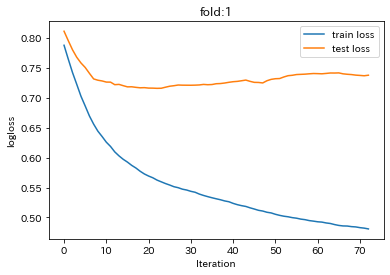

[I 2021-12-11 12:17:38,074] A new study created in memory with name: no-name-67715bbc-d6ca-453b-b17b-c5feb6278c63
feature_fraction, val_score: 0.756713:  14%|#4        | 1/7 [00:00<00:01,  5.66it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.756713:  29%|##8       | 2/7 [00:00<00:00,  5.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.756713:  43%|####2     | 3/7 [00:00<00:00,  4.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.703577:  57%|#####7    | 4/7 [00:00<00:00,  4.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.637332	Test's rmse: 0.703577
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713


feature_fraction, val_score: 0.703577:  86%|########5 | 6/7 [00:01<00:00,  5.08it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.703577:   0%|          | 0/20 [00:00<?, ?it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.758736	Test's rmse: 0.756713
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.696373:   5%|5         | 1/20 [00:00<00:11,  1.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.558213	Test's rmse: 0.696373
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.696373:  10%|#         | 2/20 [00:00<00:06,  2.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.638987	Test's rmse: 0.704579
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.695459:  15%|#5        | 3/20 [00:01<00:06,  2.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579972	Test's rmse: 0.695459
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  20%|##        | 4/20 [00:01<00:05,  2.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.581769	Test's rmse: 0.694081
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  25%|##5       | 5/20 [00:02<00:07,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.545713	Test's rmse: 0.699017
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  30%|###       | 6/20 [00:02<00:06,  2.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.587406	Test's rmse: 0.694787
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  35%|###5      | 7/20 [00:03<00:07,  1.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544462	Test's rmse: 0.698686
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  40%|####      | 8/20 [00:04<00:07,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.547296	Test's rmse: 0.700667
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  45%|####5     | 9/20 [00:04<00:05,  2.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.64154	Test's rmse: 0.70475
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  50%|#####     | 10/20 [00:04<00:05,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.561418	Test's rmse: 0.695934
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  55%|#####5    | 11/20 [00:05<00:04,  2.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.597427	Test's rmse: 0.69428
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  60%|######    | 12/20 [00:05<00:03,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.594346	Test's rmse: 0.695962
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  65%|######5   | 13/20 [00:05<00:02,  2.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605321	Test's rmse: 0.695414
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  70%|#######   | 14/20 [00:06<00:02,  2.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.567714	Test's rmse: 0.695905
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  75%|#######5  | 15/20 [00:06<00:01,  2.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.608177	Test's rmse: 0.697687
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  80%|########  | 16/20 [00:07<00:01,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573013	Test's rmse: 0.694556
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.668013	Test's rmse: 0.715647


num_leaves, val_score: 0.694081:  85%|########5 | 17/20 [00:07<00:00,  3.03it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  90%|######### | 18/20 [00:07<00:00,  2.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.557026	Test's rmse: 0.696674
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.694081:  95%|#########5| 19/20 [00:08<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.584553	Test's rmse: 0.696433
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.694081:   0%|          | 0/10 [00:00<?, ?it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.612519	Test's rmse: 0.696396
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.694081:  10%|#         | 1/10 [00:00<00:03,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.614778	Test's rmse: 0.697798
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.694081:  20%|##        | 2/10 [00:00<00:03,  2.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.580489	Test's rmse: 0.695504
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.694081:  30%|###       | 3/10 [00:01<00:02,  2.44it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.655538	Test's rmse: 0.702306
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  40%|####      | 4/10 [00:01<00:02,  2.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577574	Test's rmse: 0.688216
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  50%|#####     | 5/10 [00:02<00:02,  2.42it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.637853	Test's rmse: 0.696832
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  60%|######    | 6/10 [00:02<00:01,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.602906	Test's rmse: 0.703632
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  70%|#######   | 7/10 [00:02<00:01,  2.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.620498	Test's rmse: 0.708941
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  80%|########  | 8/10 [00:03<00:00,  2.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.585153	Test's rmse: 0.697038
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.688216:  90%|######### | 9/10 [00:03<00:00,  2.34it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.657872	Test's rmse: 0.699886
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.688216:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.635588	Test's rmse: 0.693152
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.688216:  33%|###3      | 1/3 [00:00<00:00,  2.83it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.758697	Test's rmse: 0.75774
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.688216:  67%|######6   | 2/3 [00:00<00:00,  2.64it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.758697	Test's rmse: 0.75774
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.688216:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.758697	Test's rmse: 0.75774
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.688216:   5%|5         | 1/20 [00:00<00:08,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.575617	Test's rmse: 0.69004
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.688216:  10%|#         | 2/20 [00:00<00:08,  2.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579408	Test's rmse: 0.691948
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.688216:  15%|#5        | 3/20 [00:01<00:07,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.576537	Test's rmse: 0.688817
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.688216:  20%|##        | 4/20 [00:01<00:07,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.576017	Test's rmse: 0.690979
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  25%|##5       | 5/20 [00:02<00:07,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577808	Test's rmse: 0.687547
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  30%|###       | 6/20 [00:02<00:06,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577574	Test's rmse: 0.688216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  35%|###5      | 7/20 [00:03<00:06,  2.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579047	Test's rmse: 0.689912
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  40%|####      | 8/20 [00:03<00:05,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579053	Test's rmse: 0.692124
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  45%|####5     | 9/20 [00:04<00:05,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.575614	Test's rmse: 0.69004
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  50%|#####     | 10/20 [00:04<00:04,  2.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.576537	Test's rmse: 0.688817
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  55%|#####5    | 11/20 [00:05<00:04,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.624255	Test's rmse: 0.697136
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  60%|######    | 12/20 [00:05<00:03,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577751	Test's rmse: 0.69006
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  65%|######5   | 13/20 [00:06<00:03,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577574	Test's rmse: 0.688216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  70%|#######   | 14/20 [00:06<00:02,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577243	Test's rmse: 0.688619
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  75%|#######5  | 15/20 [00:07<00:02,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.595033	Test's rmse: 0.693667
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  80%|########  | 16/20 [00:07<00:01,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.575992	Test's rmse: 0.690658
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  85%|########5 | 17/20 [00:07<00:01,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577553	Test's rmse: 0.688763
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  90%|######### | 18/20 [00:08<00:00,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577582	Test's rmse: 0.691222
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.687547:  95%|#########5| 19/20 [00:08<00:00,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.576537	Test's rmse: 0.688817
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079:   0%|          | 0/5 [00:00<?, ?it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577423	Test's rmse: 0.687079
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079:  20%|##        | 1/5 [00:00<00:01,  2.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.661184	Test's rmse: 0.712461
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079:  40%|####      | 2/5 [00:00<00:01,  2.79it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.578848	Test's rmse: 0.694181
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079:  60%|######    | 3/5 [00:01<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.587681	Test's rmse: 0.691471
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079:  80%|########  | 4/5 [00:01<00:00,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.622101	Test's rmse: 0.700506
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.687079: 100%|##########| 5/5 [00:02<00:00,  2.37it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.605493	Test's rmse: 0.69077


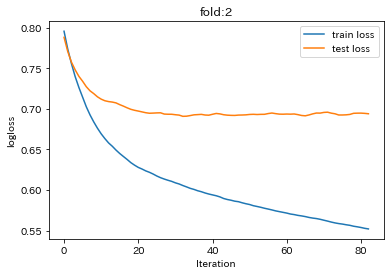

[I 2021-12-11 12:18:05,068] A new study created in memory with name: no-name-08971e2d-a651-4889-9631-c8dbc4b142a0
feature_fraction, val_score: 0.796516:  14%|#4        | 1/7 [00:00<00:01,  5.59it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.796516:  29%|##8       | 2/7 [00:00<00:00,  5.60it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.630406	Test's rmse: 0.745688


feature_fraction, val_score: 0.745688:  57%|#####7    | 4/7 [00:00<00:00,  5.17it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.745688:  71%|#######1  | 5/7 [00:01<00:00,  5.42it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516


num_leaves, val_score: 0.745688:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	Train's rmse: 0.7533	Test's rmse: 0.796516
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.734625:   5%|5         | 1/20 [00:00<00:05,  3.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.594223	Test's rmse: 0.734625
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.729569:  10%|#         | 2/20 [00:00<00:06,  2.93it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.61242	Test's rmse: 0.729569
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.729569:  15%|#5        | 3/20 [00:00<00:05,  3.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.601583	Test's rmse: 0.733423
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.729569:  20%|##        | 4/20 [00:01<00:06,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.563047	Test's rmse: 0.730939
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.726384:  25%|##5       | 5/20 [00:02<00:06,  2.20it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.601656	Test's rmse: 0.726384
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.726384:  30%|###       | 6/20 [00:02<00:07,  1.96it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.588851	Test's rmse: 0.727953
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.726384:  35%|###5      | 7/20 [00:03<00:06,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.580117	Test's rmse: 0.7355
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.726384:  40%|####      | 8/20 [00:03<00:05,  2.32it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.621364	Test's rmse: 0.733214
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.726384:  45%|####5     | 9/20 [00:03<00:04,  2.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565571	Test's rmse: 0.730442
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.670204	Test's rmse: 0.751229


num_leaves, val_score: 0.726384:  50%|#####     | 10/20 [00:04<00:03,  2.83it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  55%|#####5    | 11/20 [00:04<00:04,  2.19it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.585625	Test's rmse: 0.725058
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  60%|######    | 12/20 [00:05<00:04,  1.91it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.585286	Test's rmse: 0.727173
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  65%|######5   | 13/20 [00:06<00:03,  1.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550009	Test's rmse: 0.729713
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  70%|#######   | 14/20 [00:06<00:03,  1.71it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.591566	Test's rmse: 0.727167
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  75%|#######5  | 15/20 [00:07<00:02,  1.75it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.600712	Test's rmse: 0.729563
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  80%|########  | 16/20 [00:07<00:02,  1.75it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.598861	Test's rmse: 0.731129
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  85%|########5 | 17/20 [00:08<00:01,  1.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.554106	Test's rmse: 0.73311
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  90%|######### | 18/20 [00:08<00:01,  1.74it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.607131	Test's rmse: 0.729578
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.725058:  95%|#########5| 19/20 [00:09<00:00,  1.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.557979	Test's rmse: 0.732828
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.725058:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.586983	Test's rmse: 0.725226
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.725058:  10%|#         | 1/10 [00:00<00:07,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.576952	Test's rmse: 0.734105
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.723526:  20%|##        | 2/10 [00:01<00:05,  1.47it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.601997	Test's rmse: 0.723526
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.723526:  30%|###       | 3/10 [00:02<00:05,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.55326	Test's rmse: 0.735572
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.723526:  40%|####      | 4/10 [00:02<00:03,  1.52it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.627897	Test's rmse: 0.729477
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.722277:  50%|#####     | 5/10 [00:03<00:03,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.722277:  60%|######    | 6/10 [00:04<00:02,  1.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573117	Test's rmse: 0.735136
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.722277:  70%|#######   | 7/10 [00:04<00:01,  1.57it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.643988	Test's rmse: 0.722438
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.722277:  80%|########  | 8/10 [00:05<00:01,  1.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.563764	Test's rmse: 0.732209
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.722277:  90%|######### | 9/10 [00:06<00:00,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544912	Test's rmse: 0.733517
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.722277:   0%|          | 0/3 [00:00<?, ?it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.610652	Test's rmse: 0.732808
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.722277:  33%|###3      | 1/3 [00:00<00:00,  2.47it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.751799	Test's rmse: 0.798609
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.722277:  67%|######6   | 2/3 [00:00<00:00,  2.50it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.751799	Test's rmse: 0.798609
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.751799	Test's rmse: 0.798609
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:   5%|5         | 1/20 [00:00<00:12,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.606066	Test's rmse: 0.723089
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  10%|#         | 2/20 [00:01<00:11,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.611661	Test's rmse: 0.723291
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  15%|#5        | 3/20 [00:01<00:10,  1.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.604348	Test's rmse: 0.725296
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  20%|##        | 4/20 [00:02<00:10,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605148	Test's rmse: 0.725585
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  25%|##5       | 5/20 [00:03<00:09,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.608271	Test's rmse: 0.724487
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  30%|###       | 6/20 [00:03<00:09,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.606499	Test's rmse: 0.725698
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  35%|###5      | 7/20 [00:04<00:08,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  40%|####      | 8/20 [00:05<00:08,  1.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  45%|####5     | 9/20 [00:05<00:07,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605166	Test's rmse: 0.72559
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  50%|#####     | 10/20 [00:06<00:06,  1.62it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.655584	Test's rmse: 0.728204
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  55%|#####5    | 11/20 [00:07<00:05,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  60%|######    | 12/20 [00:07<00:05,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  65%|######5   | 13/20 [00:08<00:04,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  70%|#######   | 14/20 [00:09<00:03,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  75%|#######5  | 15/20 [00:09<00:03,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  80%|########  | 16/20 [00:10<00:02,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.614136	Test's rmse: 0.723465
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  85%|########5 | 17/20 [00:11<00:01,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  90%|######### | 18/20 [00:11<00:01,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605603	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.722277:  95%|#########5| 19/20 [00:12<00:00,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605604	Test's rmse: 0.722277
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.653967	Test's rmse: 0.726938
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277:  20%|##        | 1/5 [00:00<00:02,  1.76it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.622143	Test's rmse: 0.723927
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277:  40%|####      | 2/5 [00:00<00:01,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.702653	Test's rmse: 0.734812
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277:  60%|######    | 3/5 [00:01<00:00,  2.18it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.583425	Test's rmse: 0.728575
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277:  80%|########  | 4/5 [00:01<00:00,  2.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.661051	Test's rmse: 0.723001
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.722277: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.55409	Test's rmse: 0.730991


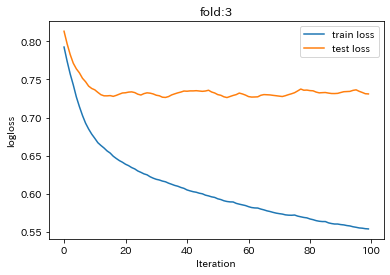

[I 2021-12-11 12:18:40,633] A new study created in memory with name: no-name-aea834e6-7814-422d-a3f0-96236f924758
feature_fraction, val_score: 0.760733:  14%|#4        | 1/7 [00:00<00:00,  6.05it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.697966:  43%|####2     | 3/7 [00:00<00:00,  5.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.642176	Test's rmse: 0.697966
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733


feature_fraction, val_score: 0.697966:  57%|#####7    | 4/7 [00:00<00:00,  5.93it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.697966:  86%|########5 | 6/7 [00:01<00:00,  5.94it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.697966:   5%|5         | 1/20 [00:00<00:02,  6.56it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.765016	Test's rmse: 0.760733
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.669469	Test's rmse: 0.700803
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.616997	Test's rmse: 0.684473


num_leaves, val_score: 0.684473:  15%|#5        | 3/20 [00:00<00:03,  4.74it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.765529	Test's rmse: 0.755651
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.684473:  20%|##        | 4/20 [00:00<00:03,  4.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.587373	Test's rmse: 0.686238
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  25%|##5       | 5/20 [00:01<00:04,  3.35it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.609599	Test's rmse: 0.68267
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  30%|###       | 6/20 [00:01<00:04,  3.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.583137	Test's rmse: 0.683672
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  35%|###5      | 7/20 [00:02<00:05,  2.46it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.607456	Test's rmse: 0.683902
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  40%|####      | 8/20 [00:02<00:05,  2.29it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.606737	Test's rmse: 0.684926
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  45%|####5     | 9/20 [00:03<00:04,  2.35it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.623176	Test's rmse: 0.686142
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  50%|#####     | 10/20 [00:03<00:04,  2.31it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.608723	Test's rmse: 0.684749
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  55%|#####5    | 11/20 [00:04<00:04,  2.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.562093	Test's rmse: 0.687629
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  60%|######    | 12/20 [00:04<00:03,  2.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.591921	Test's rmse: 0.685475
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  65%|######5   | 13/20 [00:05<00:03,  2.30it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.621294	Test's rmse: 0.684422
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  70%|#######   | 14/20 [00:05<00:02,  2.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.588977	Test's rmse: 0.68324
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  75%|#######5  | 15/20 [00:05<00:01,  2.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.606344	Test's rmse: 0.686543
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  80%|########  | 16/20 [00:06<00:01,  2.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565005	Test's rmse: 0.685049
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  85%|########5 | 17/20 [00:06<00:01,  2.23it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.61667	Test's rmse: 0.683216
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  90%|######### | 18/20 [00:07<00:00,  2.12it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.622279	Test's rmse: 0.68418
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.682670:  95%|#########5| 19/20 [00:07<00:00,  2.20it/s]

Early stopping, best iteration is:
[20]	Train's rmse: 0.64418	Test's rmse: 0.687178
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682670:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.61904	Test's rmse: 0.683067
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682670:  10%|#         | 1/10 [00:00<00:04,  2.00it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.660527	Test's rmse: 0.691559
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682670:  20%|##        | 2/10 [00:01<00:04,  1.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.567497	Test's rmse: 0.690973
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682670:  30%|###       | 3/10 [00:01<00:04,  1.65it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.61687	Test's rmse: 0.689832
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682534:  40%|####      | 4/10 [00:02<00:03,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.588071	Test's rmse: 0.682534
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682534:  50%|#####     | 5/10 [00:02<00:02,  1.73it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.613553	Test's rmse: 0.685095
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682534:  60%|######    | 6/10 [00:03<00:02,  1.85it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.649211	Test's rmse: 0.688907
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.682534:  70%|#######   | 7/10 [00:03<00:01,  1.89it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.614887	Test's rmse: 0.687564
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.680842:  80%|########  | 8/10 [00:04<00:01,  1.99it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.62251	Test's rmse: 0.680842
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.680842:  90%|######### | 9/10 [00:05<00:00,  1.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.606563	Test's rmse: 0.695804
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.680842:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.64448	Test's rmse: 0.68601
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.680842:  33%|###3      | 1/3 [00:00<00:00,  2.94it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.762452	Test's rmse: 0.764019
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.680842:  67%|######6   | 2/3 [00:00<00:00,  2.85it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.762452	Test's rmse: 0.764019
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.680842:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.762452	Test's rmse: 0.764019
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.680842:   5%|5         | 1/20 [00:00<00:06,  2.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.657965	Test's rmse: 0.691629
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679791:  10%|#         | 2/20 [00:00<00:07,  2.33it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.610988	Test's rmse: 0.679791
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679791:  15%|#5        | 3/20 [00:01<00:08,  2.12it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.612609	Test's rmse: 0.680001
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679791:  20%|##        | 4/20 [00:01<00:07,  2.22it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.637606	Test's rmse: 0.68033
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679791:  25%|##5       | 5/20 [00:02<00:06,  2.23it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.639482	Test's rmse: 0.681996
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679791:  30%|###       | 6/20 [00:02<00:06,  2.17it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.623344	Test's rmse: 0.683442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  35%|###5      | 7/20 [00:03<00:06,  2.08it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.610973	Test's rmse: 0.679743
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  40%|####      | 8/20 [00:03<00:05,  2.18it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.631381	Test's rmse: 0.680868
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  45%|####5     | 9/20 [00:04<00:04,  2.23it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.637591	Test's rmse: 0.680312
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  50%|#####     | 10/20 [00:04<00:04,  2.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.596626	Test's rmse: 0.687756
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  55%|#####5    | 11/20 [00:05<00:04,  2.05it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.62251	Test's rmse: 0.680842
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  60%|######    | 12/20 [00:05<00:03,  2.06it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.610983	Test's rmse: 0.679791
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  65%|######5   | 13/20 [00:06<00:03,  2.05it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.637597	Test's rmse: 0.680319
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  70%|#######   | 14/20 [00:06<00:02,  2.13it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.62251	Test's rmse: 0.680842
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  75%|#######5  | 15/20 [00:06<00:02,  2.18it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.639601	Test's rmse: 0.681853
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  80%|########  | 16/20 [00:07<00:01,  2.19it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.622501	Test's rmse: 0.680866
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  85%|########5 | 17/20 [00:07<00:01,  2.15it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.613578	Test's rmse: 0.681476
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  90%|######### | 18/20 [00:08<00:00,  2.12it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.611163	Test's rmse: 0.679969
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.679743:  95%|#########5| 19/20 [00:08<00:00,  2.11it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.62251	Test's rmse: 0.680842
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.62251	Test's rmse: 0.680842
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743:  20%|##        | 1/5 [00:00<00:02,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579498	Test's rmse: 0.691637
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743:  40%|####      | 2/5 [00:01<00:01,  1.88it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.569703	Test's rmse: 0.687357
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743:  60%|######    | 3/5 [00:01<00:00,  2.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.672496	Test's rmse: 0.694449
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743:  80%|########  | 4/5 [00:01<00:00,  2.31it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.563046	Test's rmse: 0.700137
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.679743: 100%|##########| 5/5 [00:02<00:00,  2.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.631595	Test's rmse: 0.683592


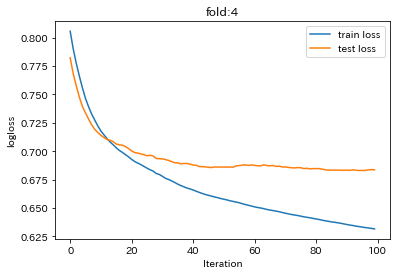

RMSE: [0.7108628371812713, 0.6987830622470659, 0.6870786345479166, 0.7222772845208271, 0.6797429569607546]
RMSE: 0.6997489550915671


In [ ]:
y_train_dropna = y_train_dropna.reset_index(drop=True)

kf = KFold(n_splits=5)

groups = feature[:, 0]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(kf.split(feature, y_train_dropna, groups)):
    X_train_kf, X_test_kf = feature[train_index], feature[test_index]
    y_train_kf, y_test_kf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_kf, y_train_kf)
    lgb_test = lgb.Dataset(X_test_kf, y_test_kf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_kf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_kf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

In [ ]:
print("TSNE RMSE:", np.mean(cv_result))

TSNE RMSE: 0.6997489550915671
